In [1054]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation

npr.seed(0)

In [1055]:
from scipy.io import loadmat
import os
path = r"W:\Data\2AFC_Behavior\opto_145"
os.chdir(path)
mouse = loadmat("glmhmm.mat")
w = (mouse['w']);
choices = (mouse['ans'])

In [1056]:
true_choices = [];

for sess in range(choices.shape[0]):
    a = np.zeros((choices.shape[1],1))
    for trial in range(choices.shape[1]):
        
        a[trial] = np.array(choices[sess][trial])
        #print(a)
    true_choices.append(a.astype(int))

true_choices = list(true_choices)


In [1057]:
# Set the parameters of the GLM-HMM
num_states = 3    # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = w.shape[2]         # input dimensions
print(input_dim)

7


In [1058]:
num_sess = w.shape[0] # number of example sessions
num_trials_per_sess = w.shape[1] # number of trials in a session
print(num_trials_per_sess)
#inpts = list(inpts) #convert inpts to correct format

215


In [1059]:
inpts = [];
for sess in range(w.shape[0]):
    a = np.zeros((w.shape[1],w.shape[2]))
    for trial in range(w.shape[1]):
        for weight in range(w.shape[2]):
            a[trial][weight] = np.array(w[sess][trial][weight])
        #print(a)
    inpts.append(a)

inpts = list(inpts)


In [1060]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

In [1061]:
prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

fit_map = map_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

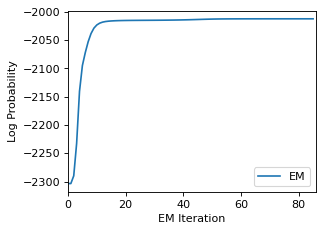

In [1062]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
#plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

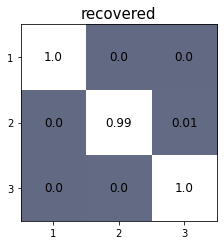

In [1063]:
plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

In [1064]:
# Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices, inpts)]

Text(0, 0.5, 'p(state)')

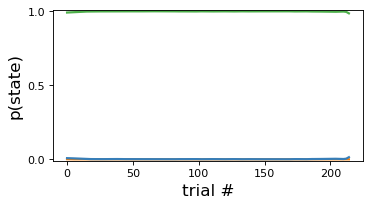

In [1065]:
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#992488', '#111111', '#45AB45', '#988811']
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 10
#session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

Text(0.5, 1.0, 'Weight recovery')

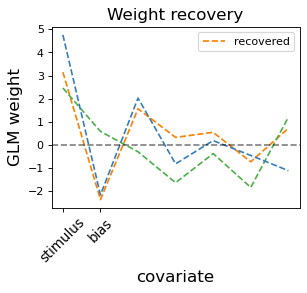

In [1066]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

recovered_weights = map_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
       # plt.plot(range(input_dim), gen_weights[k][0], marker='o',
        #         color=cols[k], linestyle='-',
         #        lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
       # plt.plot(range(input_dim), gen_weights[k][0], marker='o',
        #         color=cols[k], linestyle='-',
        #         lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

Text(0.5, 1.0, 'Weight recovery')

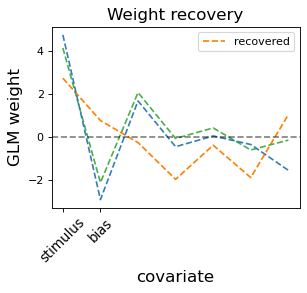

In [1067]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
       # plt.plot(range(input_dim), gen_weights[k][0], marker='o',
        #         color=cols[k], linestyle='-',
         #        lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
       # plt.plot(range(input_dim), gen_weights[k][0], marker='o',
        #         color=cols[k], linestyle='-',
        #         lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)